# Data exploration

In [1]:
import tensorflow as tf
import tensorflow.keras as keras
from tensorflow.keras import backend as K
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import tensorflow_hub as hub
import os
import PIL.Image as Image
import numpy as np
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

os.environ["CUDA_VISIBLE_DEVICES"]= "-1"

C:\Users\lyeso\anaconda3\envs\exts-ml\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
# Load training data form NPZ file

train_data = "train.npz"
images = np.load(train_data)["pixels"]
labels = np.load(train_data)["labels"]

# Create a dictionnary for labels
labels_dict = {0: 'bike', 1 : 'car', 2: 'motorcycle', 3: 'other', 4:'truck', 5: 'van'}

In [3]:
images[:,:,:,0].shape

(280, 299, 299)

In [4]:
def show_image_category(X, y, category):

    i = 0
    idx = 0
    
    while i < 3 :
        
        if y[idx] == category :
            img = X[idx]
            # Print label using the output vector y
            print('Label:', labels_dict[y[idx]])
        
            # Plot image with pyplot
            fig = plt.imshow(img)
            fig.axes.get_xaxis().set_visible(False)
            fig.axes.get_yaxis().set_visible(False)
            plt.show()
            i += 1
            idx += 1
        
        else :
            idx += 1

# Display images using the show_image_category

Label: bike


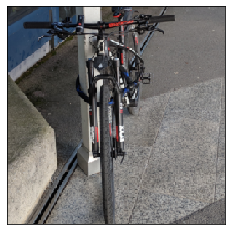

Label: bike


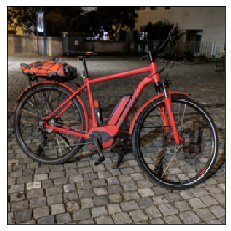

Label: bike


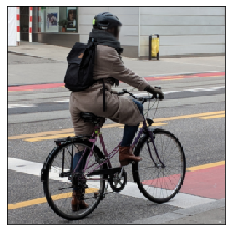

Label: car


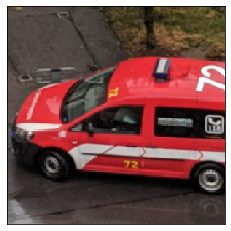

Label: car


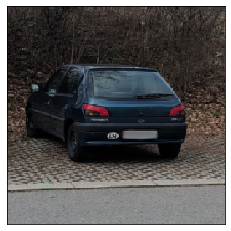

Label: car


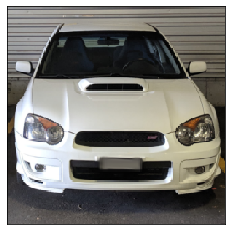

Label: motorcycle


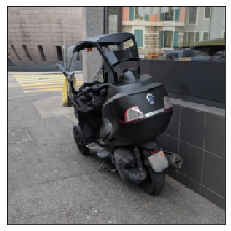

Label: motorcycle


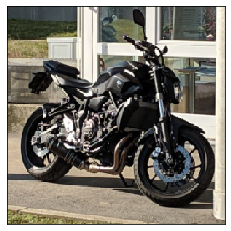

Label: motorcycle


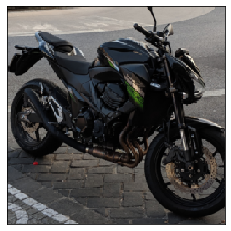

Label: other


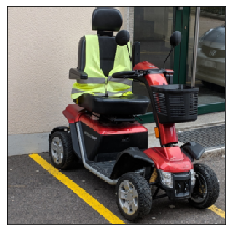

Label: other


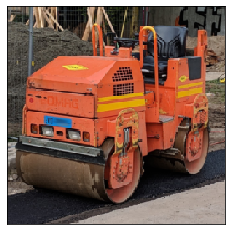

Label: other


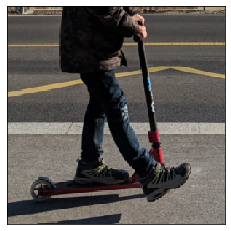

Label: truck


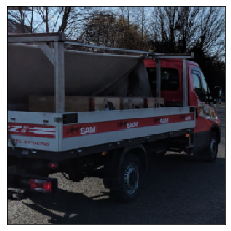

Label: truck


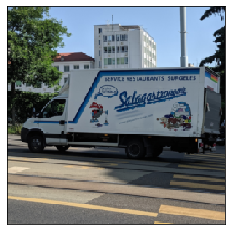

Label: truck


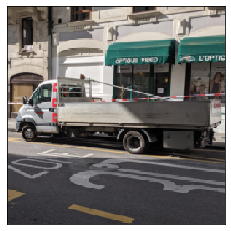

Label: van


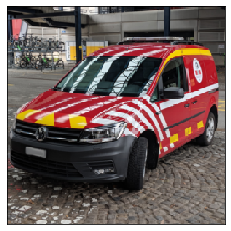

Label: van


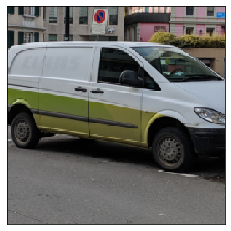

Label: van


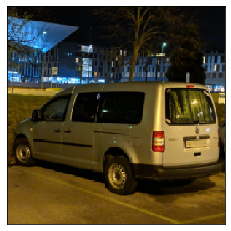

In [5]:
# Show the first images from the training set in each "cat" category
for cat in list(set(labels)):
    show_image_category(images, labels, cat)

# Principal Components Analysis on high-level features

In [6]:
from sklearn.decomposition import PCA

In [7]:
features = np.load(train_data)["features"]
print("Features", features.shape)

Features (280, 2048)


**This 2-dimension array is sized 280 (each image) x 2048 features from Inception V3**

### Standardizing features value


In [8]:
print("Values go from ",features.min(),"to",features.max(),'with a standard deviation of', features.var())

Values go from  0.0 to 4.475486 with a standard deviation of 0.07500374


In [9]:
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler

# Create Standard scaler
scaler = StandardScaler()
minmax = MinMaxScaler() # tried both scalers


# Rescale data
features_rescaled = scaler.fit_transform(features)


print("Values go from ",features_rescaled.min(),"to",features_rescaled.max(),'with a standard deviation of', features_rescaled.var())

Values go from  -2.0803049 to 12.92061 with a standard deviation of 1.0000002


In [10]:
# Create PCA transformer with no limit on the number of components

pca = PCA(n_components=None)

# Apply PCA to rescaled data
features_projected_rescaled = pca.fit_transform(features_rescaled, y = labels)


In [11]:
# Proportion of variance explained
pve = pca.explained_variance_ratio_
print(pve.shape)
pve.sum()

(280,)


1.0

In [12]:
pca.components_.shape # 280 components x 2048 features

(280, 2048)

### Explained Variance

**As we can see here we "only" have 280 components as we cannot reach 2048 components (because of a lack of images) ==> So 280 components here explain for 100% of the variance**

Let's look at the cumulative sum of the pve for all the components

In [13]:
cumulative_pve = pve.cumsum()

### Let's plot it : 

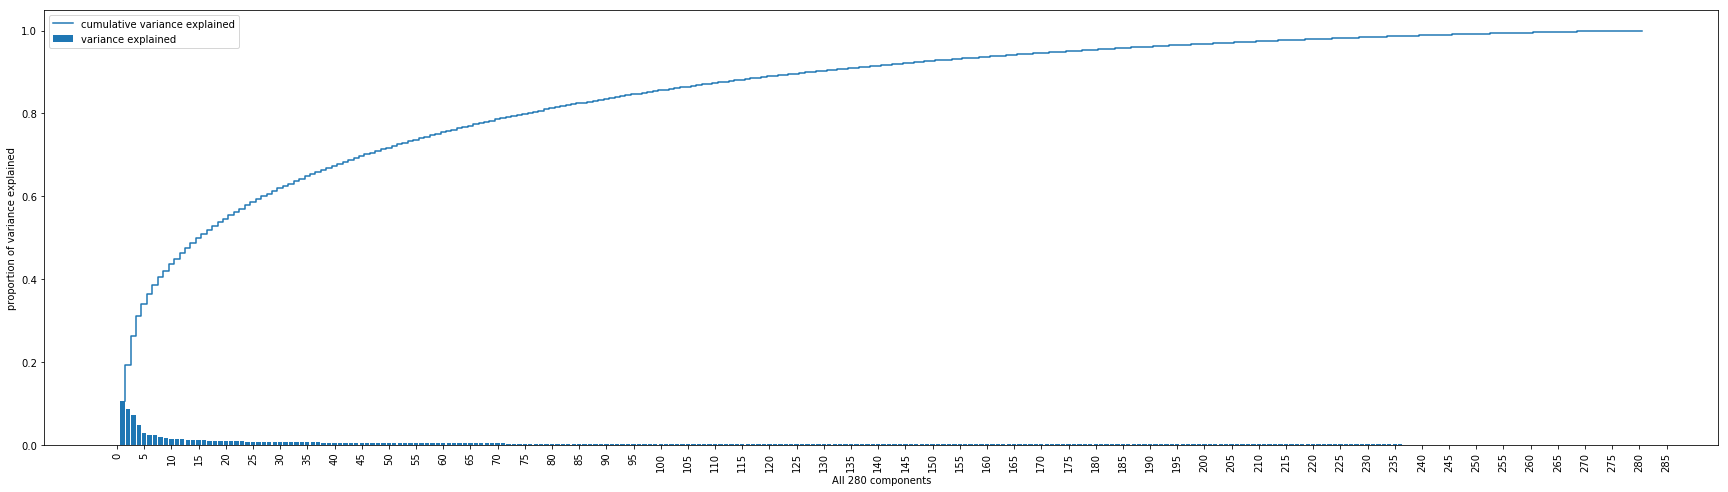

In [14]:
# Create two plots: one for the loss value, one for the accuracy
fig = plt.subplots(figsize=(30, 8))


# Create bar plot
xcor = np.arange(1, len(pve) + 1) # 1,2,..,n_components
plt.bar(xcor, pve, label="variance explained")
plt.xticks(xcor)

# Add cumulative sum

plt.step(
    xcor+0.5, # 1.5,2.5,..,n_components+0.5
    cumulative_pve, # Cumulative sum
    label='cumulative variance explained'
)

# Add labels
plt.xlabel('All 280 components')
plt.xticks(np.arange(0, max(xcor)+10, 5), rotation=90)
plt.ylabel('proportion of variance explained')
plt.legend()
plt.show()


In [15]:
# Create a function to print the number components for the part of variance explained 

def pve_x(percent_explained, cum_pve_array):
    pve_index = ((cum_pve_array >= percent_explained) == True).argmax()
    real_pve = cum_pve_array[pve_index]
    print(pve_index + 1,'components explain for more than', percent_explained*100, '% of the variance (exactly',np.round(real_pve*100,2),"%)")

In [16]:
for i in range(10,100,10):
    pve_x(i/100,cumulative_pve)

1 components explain for more than 10.0 % of the variance (exactly 10.64 %)
3 components explain for more than 20.0 % of the variance (exactly 26.32 %)
4 components explain for more than 30.0 % of the variance (exactly 31.15 %)
8 components explain for more than 40.0 % of the variance (exactly 40.38 %)
16 components explain for more than 50.0 % of the variance (exactly 50.9 %)
28 components explain for more than 60.0 % of the variance (exactly 60.61 %)
46 components explain for more than 70.0 % of the variance (exactly 70.09 %)
76 components explain for more than 80.0 % of the variance (exactly 80.16 %)
128 components explain for more than 90.0 % of the variance (exactly 90.02 %)


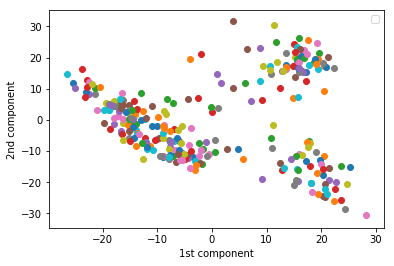

In [17]:
# Plot each kind of wine
fig = plt.figure()
for idx in range(280):
    plt.scatter(features_projected_rescaled[idx, 0], features_projected_rescaled[idx, 1])

# Labels and legend
plt.legend()
plt.xlabel('1st component')
plt.ylabel('2nd component')
plt.show()

### We can visually notice that we have 3 disinct clusters of features, let's add the labels for each image

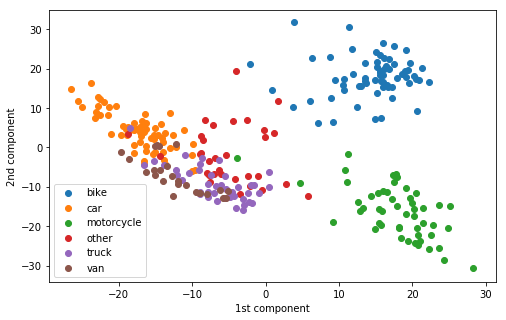

In [18]:
# Plot each kind of wine
fig = plt.figure(figsize = (8,5))
for kind in [0, 1, 2, 3, 4, 5]: 
    # Wine samples of this type
    idx = (labels == kind)

    # Plot their components
    plt.scatter(
        features_projected_rescaled[idx, 0], features_projected_rescaled[idx, 1],
        label='{}'.format(labels_dict[kind])
    )

# Labels and legend
plt.legend(loc='lower left')
plt.xlabel('1st component')
plt.ylabel('2nd component')
plt.show()

## Here, we can observe that bikes and motorcycles are the only positives on the first component. It could be a component linked to the size of wheels, seats or presence of the handling bar or the absence of body / windows for example.

These 2 components explaining for less than 20% of variance, but would possibly be enough to understand bikes and motorcycles.

**By curiosity let's check what is the "other" category which are positives in first component.**


In [19]:
### Create a function to show image based on the first component + labels : 
def show_image_1stcomponent(category, suporinf, threshold) :
    if suporinf == "sup":
        
        # Check if image meets requirements
        images_conditions = ((labels == category)  & (features_projected_rescaled[:,0]> threshold))
    
        i = 0 # first position
        
        for img in images_conditions : # test if image meets requirements
            if img == True:
                fig = plt.imshow(images[i])
                fig.axes.get_xaxis().set_visible(False)
                fig.axes.get_yaxis().set_visible(False)
                plt.show()
            i += 1 # increment image position after each image
            
    else :
        
        # Check if image meets requirements
        images_conditions = ((labels == category)  & (features_projected_rescaled[:,0] <= threshold))
    
        i = 0 # first position
        
        for img in images_conditions : # test if image meets requirements
            if img == True:
                fig = plt.imshow(images[i])
                fig.axes.get_xaxis().set_visible(False)
                fig.axes.get_yaxis().set_visible(False)
                plt.show()
            i += 1 # increment image position after each image

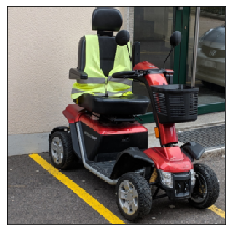

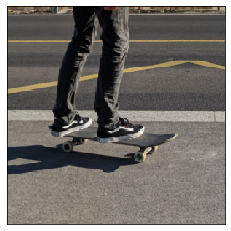

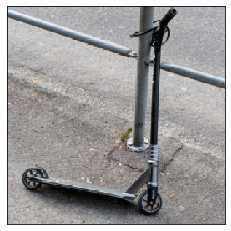

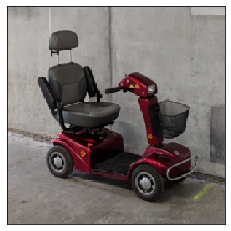

In [25]:
show_image_1stcomponent(3,"sup", 0) # print "others" (labels = 3) with 1st Component > 0 